# Colaboratoryで実行する場合
以下を実行して、外部ファイルをダウンロードしてください。   
**このセルはColaboratoryを起動するたびに必要となります**

In [ ]:
##################################
### Colaboratoryのみ以下を実行 ###
##################################
import sys
if 'google.colab' in sys.modules:
    !wget -P ./sound http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc2/sound/1-Violin-music.wav
    !mkdir fig

# 音の情報処理1：音の表現（入力・再生・可視化）


第3回で必ず演習してきていただきたいのは以下の４つです。   
ちょっとうんざりするかもしれませんが、実行だけはしてきてください。

- SoundProcessing1.ipynb
- SoundProcessing2.ipynb
- SoundProcessing3.ipynb
- SoundProcessing4.ipynb

また、発展的演習は以下の1つです。  

- MFCC.ipynb：MFCCをつかって音声や楽器の違いを聞き分けよう


## 1  音ファイル
### 1.0 これから処理する音ファイルを確認してください

このノートブックが置かれているフォルダに、`1-Violin-music.wav`という音ファイルがあります。   
これは、ヴァイオリンの独奏を収録したものです。   
エクスプローラーやFinderなどでこのファイルをダブルクリックすれば、OSにプリインストールされているサウンドプレイヤ（Windowsであれば"Windows Media Player"など）で再生することができるはずです。   
どのような音楽か聞いてみてください。

### 1.1 音ファイルの読み込み
以下のコードで音ファイルを読み込んでみましょう。  

In [1]:
import wave
wavfile = wave.open('sound/1-Violin-music.wav', 'rb')

### 1.2 音ファイルのパラメータ
拡張子がwavとなっている場合、これは「RIFF waveform Audio Format」という音声ファイルフォーマットという形式で記録されています。   
このフォーマットは非圧縮です（たとえばmp3などは人間の耳では聞き取れない高周波帯域の音情報を除去している圧縮音響フォーマットです）が、ファイルの冒頭（ヘッダ）に、この音ファイルに関する様々なパラメータが記録されています。  

どのようなパラメータが記録されているかは以下のコードで読み取ることができます。

In [2]:
# WAVファイルに記録されている情報の表示
print("Channel num : ", wavfile.getnchannels()) # モノラルならば1, ステレオなら2（1是单声道2是立体声）
print("Sample size : ", wavfile.getsampwidth()) # 音声データ1サンプルあたりのバイト数。ビット深度とも呼ぶ。2なら2-byte(16-bit), 3なら3-byte(24-bit)など
                                                #返回每一帧的字节宽度
print("Sampling rate : ", wavfile.getframerate()) # サンプリングレート。1秒当たり何回データを記録するか    返回实例的频率（单位：Hz）。
print("Frame num : ", wavfile.getnframes()) # このファイルのフレーム数    返回音频的帧数
print("Sec : ", float(wavfile.getnframes()) / wavfile.getframerate()) # フレーム数/サンプリングレート=録音時間
print("Prams : ", wavfile.getparams()) # このファイルに記録されている各種パラメータを一気に出力

Channel num :  1
Sample size :  2
Sampling rate :  48000
Frame num :  536465
Sec :  11.176354166666666
Prams :  _wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=536465, comptype='NONE', compname='not compressed')


### 1.3 音声ファイルの再生（オプション）
<font color='red'>Colaboratoryでは実行できません！</font>

PyAudioというライブラリを使えば、Pythonから音を再生することができます。  
これにはまずオーディオストリームを生成しなければいけません。
音を実際に再生するためには、ファイルから音情報をメモリに読み込み、それを波形（実際には電流）に変換してスピーカやイヤホンに送電しますが、
音声データはサイズが非常に大きかったり、時にはサイズが決まっていない（音声情報を生成しながら再生する場合など）ことがありますので、
ファイルを一気に最後まで読み込むのではなく、先頭から小分けにして読み込みます。  
このときの小分けのサイズをチャンク、それが読み込まれている場所をバッファと呼びます。  

このファイルは1サンプルあたり16bit=2byteで記録されていましたね。  
例えば、チャンクサイズが1024なら、536465フレームの音声ファイルを1024フレーム=2048bitずつに切り分けてバッファに読み込んで順に再生していくことになります。  
1024フレームを再生し終えるまでに次の音声ファイルの読み込みが間に合わなければ、音が途切れることになります。  
何チャンク分になるか数えて見ましょう。コード中でnumという変数で数えています。  
このファイルは536465フレームですから、536465/1024=523あまり913ということで、523回目で913フレーム×2byte=1826byteを読み込んで終了しています。
### チャンクサイズを小さくするとどうなるか試してみましょう。例えば1024-->16フレームにするとどうなりますか？

In [3]:
####################################################
####################################################
####################################################
####################################################
######## 音が出るので注意してください！！！！ ######
####################################################
####################################################
####################################################
####################################################
####################################################

import wave
import pyaudio

# wavファイルを読み込み
wavfile = wave.open('sound/1-Violin-music.wav', 'rb')

# PyAudioのインスタンスを生成
p = pyaudio.PyAudio()

# Streamを生成
stream = p.open(format=p.get_format_from_width(wavfile.getsampwidth()),
                channels=wavfile.getnchannels(),
                rate=wavfile.getframerate(),
                output=True)
# チャンク単位でストリームに出力し音声を再生
chunk = 1024

data = wavfile.readframes(chunk) # wavfileからdataに1つ目のチャンク1024フレームを取ってくる
num = 1
while len(data) > 0: # wavfileをすべて読み込み終わったら終わり
    stream.write(data) # dataをバッファに送る（1024フレーム×1チャンネル×2byte=2048byte
    data = wavfile.readframes(chunk) # wavfileから次のチャンクを取ってくる
    print(num, ": len(data)=", len(data))
    num+=1
    
stream.stop_stream()
stream.close()
p.terminate()

1 : len(data)= 2048
2 : len(data)= 2048
3 : len(data)= 2048
4 : len(data)= 2048
5 : len(data)= 2048
6 : len(data)= 2048
7 : len(data)= 2048
8 : len(data)= 2048
9 : len(data)= 2048
10 : len(data)= 2048
11 : len(data)= 2048
12 : len(data)= 2048
13 : len(data)= 2048
14 : len(data)= 2048
15 : len(data)= 2048
16 : len(data)= 2048
17 : len(data)= 2048
18 : len(data)= 2048
19 : len(data)= 2048
20 : len(data)= 2048
21 : len(data)= 2048
22 : len(data)= 2048
23 : len(data)= 2048
24 : len(data)= 2048
25 : len(data)= 2048
26 : len(data)= 2048
27 : len(data)= 2048
28 : len(data)= 2048
29 : len(data)= 2048
30 : len(data)= 2048
31 : len(data)= 2048
32 : len(data)= 2048
33 : len(data)= 2048
34 : len(data)= 2048
35 : len(data)= 2048
36 : len(data)= 2048
37 : len(data)= 2048
38 : len(data)= 2048
39 : len(data)= 2048
40 : len(data)= 2048
41 : len(data)= 2048
42 : len(data)= 2048
43 : len(data)= 2048
44 : len(data)= 2048
45 : len(data)= 2048
46 : len(data)= 2048
47 : len(data)= 2048
48 : len(data)= 2048
4

387 : len(data)= 2048
388 : len(data)= 2048
389 : len(data)= 2048
390 : len(data)= 2048
391 : len(data)= 2048
392 : len(data)= 2048
393 : len(data)= 2048
394 : len(data)= 2048
395 : len(data)= 2048
396 : len(data)= 2048
397 : len(data)= 2048
398 : len(data)= 2048
399 : len(data)= 2048
400 : len(data)= 2048
401 : len(data)= 2048
402 : len(data)= 2048
403 : len(data)= 2048
404 : len(data)= 2048
405 : len(data)= 2048
406 : len(data)= 2048
407 : len(data)= 2048
408 : len(data)= 2048
409 : len(data)= 2048
410 : len(data)= 2048
411 : len(data)= 2048
412 : len(data)= 2048
413 : len(data)= 2048
414 : len(data)= 2048
415 : len(data)= 2048
416 : len(data)= 2048
417 : len(data)= 2048
418 : len(data)= 2048
419 : len(data)= 2048
420 : len(data)= 2048
421 : len(data)= 2048
422 : len(data)= 2048
423 : len(data)= 2048
424 : len(data)= 2048
425 : len(data)= 2048
426 : len(data)= 2048
427 : len(data)= 2048
428 : len(data)= 2048
429 : len(data)= 2048
430 : len(data)= 2048
431 : len(data)= 2048
432 : len(

## 2. 音波形の描画

### 2.1 波形のデータ変換とグラフ化

音の波形をグラフとして描画してみましょう。  
この時、横軸を時間にするためにはどうしたらいいでしょうか？   
上で書いた通り、この音声波形が1秒間に何回サンプリングされたかは、`wavfile.getframerate()`で知ることができました。  
よって、x軸は、そのデータのインデックスを` wavfile.getframerate()`で割った値をラベルにしてあげればいいということになりますね。

duration:  536465


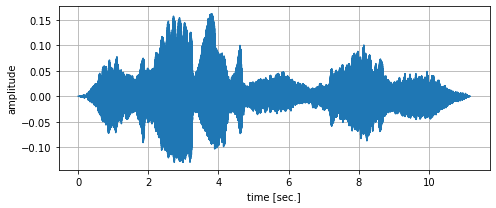

In [4]:
%matplotlib inline

import wave
import numpy as np
import matplotlib.pyplot as plt

wavfile = wave.open("sound/1-Violin-music.wav" , "rb" ) # オーディオファイルを開く
# wavfileのデータを最後まで一気に読み込む
#（データサイズが大きいファイルを読み込むときは、読み込むサイズを指定しないとPCがフリーズします！）
data = wavfile.readframes(wavfile.getnframes())
sampling_rate = wavfile.getframerate()  # フレームレート[1/s]
sample_size = wavfile.getsampwidth() # 1サンプルあたりのサイズ
# wavfileをクローズしておく
wavfile.close()

# バイナリデータをint型に変換
data = np.frombuffer(data, dtype= "int16") 

# 1サンプルあたりsample_sizeバイトで表されているということは、
# 表現可能な階調は2の(8byte x sample_size)乗
# ただし、波形は正と負があるため、正・負それぞれの領域は、その1/2階調の細かさまで表現できる
# これを最大値として正規化
amp  = 2**(8 * sample_size) / 2
data = data/amp
print('duration: ', len(data))

# X軸をサンプル数から経過時間にするため、X軸の座標を生成
# このデータは0秒からlen(data)/sampling_rate秒まである
# 隣り合うデータとの時間幅は、1.0/sampling_rate秒
x = np.arange(0, len(data)/sampling_rate, 1.0/sampling_rate)

# 波形を描画
fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備

ax.plot(x, data)
ax.set_xlabel("time [sec.]")
ax.set_ylabel("amplitude")
ax.grid()
fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing1-1.png') # 図を画像として保存

### 2.2 波形の拡大
先ほどの波形を拡大してみましょう。  
連続的な波のように見える波形は、拡大すると離散的な値のつながりであることが分かります。

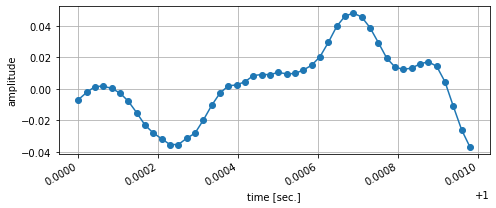

In [5]:
# 波形を描画
start = 1.0 # 開始から60秒後を起点とする
duration = 0.001 # 1ミリ秒分を描画

fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備

ax.plot(x[round(start*sampling_rate):round(start*sampling_rate+duration*sampling_rate)], 
        data[round(start*sampling_rate):round(start*sampling_rate+duration*sampling_rate)], marker="o")

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')# 軸を右揃えにして斜めに
ax.grid() # グリッド線を描画
ax.set_xlabel("time [sec.]") # X軸のラベル
ax.set_ylabel("amplitude") # Y軸のラベル
fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing1-2.png') # 図を画像として保存